### Deep cross network
- https://arxiv.org/abs/1708.05123



In [450]:
!pip install lightfm
!pip install  recommenders



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [451]:
import warnings
warnings.filterwarnings("ignore")

In [452]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [453]:

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)


In [454]:
SEED = 42
np.random.seed(SEED)

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [455]:
rating_df = pd.read_csv('Ratings.csv')
users_df = pd.read_csv('Users.csv')
book_df = pd.read_csv('Books.csv')

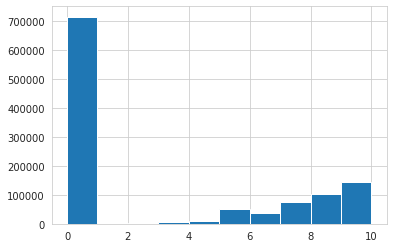

In [456]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df=pd.merge(rating_df,users_df,on="User-ID",how="left")
rating_df['Book-Rating'].hist()

In [457]:
rating_df.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN


In [458]:
rating_df=rating_df[rating_df['Book-Rating']>2]

In [459]:
y = rating_df.groupby('Book-Title').count()['Book-Rating']>=50
books = y[y].index

In [460]:
rating_df = rating_df[rating_df['Book-Title'].isin(books)]
rating_df.shape

(64308, 12)

In [461]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] >= 50
userIndex = x[x].index
rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]

In [462]:
rating_df.rename(columns = {'User-ID':'userID', 'Book-Title':'itemID','Book-Rating':'rating'}, inplace = True)

In [463]:
rating_df.rename(columns = {'Book-Author':'author', 'Year-Of-Publication':'year','Publisher':'publisher','Age':'age'}, inplace = True)

In [464]:
final_ratings=rating_df

In [465]:
rating_df=rating_df[['userID','itemID','rating','author','age','publisher']]

In [466]:
rating_df.head(1)

,userID,itemID,rating,author,age,publisher
28142,6575,Five Quarters of the Orange,8,Joanne Harris,NaN,William Morrow &amp; Company


### Prepare Train Test dataset 

In [467]:
test_df=rating_df.groupby('userID').head(20)
test_df.shape

(740, 6)

In [468]:
train_df=rating_df[~rating_df.isin(test_df).all(1)]
train_df.shape

(2547, 6)

In [469]:
allbooks=list(train_df.itemID.unique())

In [470]:
test_df=test_df[test_df.itemID.isin(allbooks)]

### Prepare train test set

In [471]:
authors =list( train_df['author'])

In [472]:
authors=iter(authors)

In [473]:
dataset = Dataset()

In [474]:
dataset.fit(users=train_df['userID'], 
            items=train_df['itemID'],
             item_features=authors)

# quick check to determine the number of unique users and items in the data
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')

Num users: 37, num_items: 617.


In [475]:
item_features = dataset.build_item_features((x, y) for x,y in zip(train_df.itemID,authors))


### Light FM

In [476]:
#  TOP K 
K = 20
# model learning rate
LR = 0.01
# no of latent factors
NO_COMPONENTS = 50

#epochs
EPOCHS=100
# no of threads to fit model
THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6


In [477]:
interactions, weights = dataset.build_interactions(train_df.iloc[:, 0:3].values)

train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, 
    random_state=np.random.RandomState(SEED))

In [478]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LR, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

In [479]:
model.fit(interactions=train_interactions,
           item_features=item_features,
           epochs=EPOCHS
           )

### Model evaluation

In [480]:

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [481]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(train_df, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model, 
                                              num_threads=THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 19.6 seconds for prepare and predict all data.


In [482]:
all_predictions.sample(5, random_state=SEED)


,userID,itemID,prediction
1943,21014,The Other Boleyn Girl,-0.705443
17989,219683,The Secret Life of Bees,-1.915884
3511,31315,Animal Dreams,-1.478907
3353,31315,Seabiscuit: An American Legend,-1.835621
13402,114368,American Psycho (Vintage Contemporaries),-2.081969


### Model Evaluation

In [496]:
recommendations=all_predictions.sort_values(by=['userID','prediction'],ascending=[True,False])

In [497]:
recommendations=recommendations.groupby('userID').head(20)

In [498]:
recommendations

,userID,itemID,prediction
328,6575,The Cider House Rules,0.242625
462,6575,Atonement: A Novel,0.151526
507,6575,A Fine Balance,0.064101
371,6575,SHIPPING NEWS,-0.050062
460,6575,Cold Mountain : A Novel,-0.110630
...,...,...,...
20705,258534,The Alienist,-0.184440
20843,258534,We'll Meet Again,-0.212692
20844,258534,The Dead Zone,-0.236777
20664,258534,Misery,-0.236950


In [499]:
test_df

,userID,itemID,rating,author,age,publisher
28142,6575,Five Quarters of the Orange,8,Joanne Harris,NaN,William Morrow &amp; Company
28143,6575,The Divine Secrets of the Ya-Ya Sisterhood: A ...,8,Rebecca Wells,NaN,HarperTorch
28155,6575,Divine Secrets of the Ya-Ya Sisterhood: A Novel,8,Rebecca Wells,NaN,Perennial
28157,6575,One Hundred Years of Solitude,8,Gabriel Garcia Marquez,NaN,Perennial
28161,6575,Bel Canto: A Novel,9,Ann Patchett,NaN,Perennial
...,...,...,...,...,...,...
1080816,258534,All That Remains (Kay Scarpetta Mysteries (Pap...,9,Patricia D. Cornwell,32.0,Avon
1080836,258534,Hannibal,9,Thomas Harris,32.0,Del Sol Press
1080871,258534,The Body Farm,9,Patricia Daniels Cornwell,32.0,Berkley Publishing Group
1080872,258534,From Potter's Field,9,Patricia Daniels Cornwell,32.0,Berkley Publishing Group


#### Hit rate

In [500]:
total=0
hit=0
for index, row in recommendations.iterrows():
    uid=row['userID']
    results=list(row['itemID'])
    total+=1
    for rs in results:
        
        if(((test_df['itemID'].isin(results)) & (test_df['userID'] ==uid)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.0


#### MAP@K

In [501]:
total=0
hit=0
for index, row in recommendations.iterrows():
    uid=row['userID']
    results=list(row['itemID'])
    total+=1
    for rs in results:
        
        if(((test_df['itemID'].isin(results)) & (test_df['userID'] ==uid)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.0


###  Retrieve the top N similar items

In [502]:
_, item_embeddings = model.get_item_representations(features=item_features)
similar_items(item_id=10, 
              item_features=item_features, 
              model=model)

,itemID,score
0,143,0.857725
1,433,0.761222
2,267,0.743899
3,195,0.715937
4,1,0.710905
5,34,0.707316
6,4,0.696278
7,154,0.692421
8,528,0.688565
9,139,0.677418
